In [1]:
%load_ext autoreload
%autoreload 2

from readers import *
from datalib import *
from filters import *
import config.config_jump_detection as config
import matplotlib.pyplot as plt
import time as t
%matplotlib notebook

script_starting_time = t.time()

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
expected_jumps = 3
expected_impacts = 2
window_lengths = range(3,41)
best_scores_amount = 5

In [3]:
start_time = t.time()
print("Reading demonstration data")

force_ext = []
position_data = []
velocity_data = []

starting_indices = []
ending_indices = []

for i in range(len(config.demos)):
    demo = config.demos[i]
    print(f'Reading demonstration file {demo}')

    force_ext.append(DataSet())
    position_data.append(PositionDataSet())
    velocity_data.append(PositionDataSet())

    # Read data
    franka_reader = FrankaStateReader(demo)
    starting_position = None
    ending_position = franka_reader.last_datapoint().value.position
    starting_index = None
    ending_index = None
    
    while not franka_reader.end():
        dp = franka_reader.next_datapoint()
        time = dp.time
        franka_state = dp.value
        
        if starting_position is None:
            starting_position = franka_state.position
        elif starting_index is None:
            if franka_state.distance(starting_position) > 0.01:
                starting_index = len(force_ext[i])
        elif ending_index is None:
            if franka_state.distance(ending_position) < 0.01 and np.linalg.norm(franka_state.velocity) < 0.01:
                ending_index = len(force_ext[i]) + 1

        force_ext[i].append(DataPoint(time, franka_state.force_external_magnitude))
        position_data[i].append(PositionDataPoint(time, franka_state.position))
        velocity_data[i].append(PositionDataPoint(time, franka_state.velocity))

    if ending_index is None:
        ending_index = -1
    else:
        ending_index = min(len(force_ext[i]) - 1, ending_index+30)
    
    starting_indices.append(starting_index)
    ending_indices.append(ending_index)
        
    # Align time
    force_ext[i].align_time()
    position_data[i].align_time()
    velocity_data[i].align_time()

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Reading demonstration data
Reading demonstration file data/demo20.bag
Reading demonstration file data/demo21.bag
Reading demonstration file data/demo22.bag
Reading demonstration file data/demo23.bag
Reading demonstration file data/demo24.bag
--- 8.691890478134155 seconds ---
Done


In [4]:
def calc_proposed_bound(demo_local_maxima, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_jumps
    local_maxima_copy = demo_local_maxima.copy()
    local_maxima_copy.sort(reverse=True)
    return local_maxima_copy[expected_jumps_]

def propose_bound(proposed_bounds):
    return max(proposed_bounds)

def calc_score(detected_jumps, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_jumps
    return (expected_jumps_ - detected_jumps)**2

In [5]:
start_time = t.time()
print("Analyzing different window lengths")

scores1 = []
proposed_bounds1 = []

for window_length in window_lengths:

    jump_detector = config.jump_detector.copy()
    jump_detector.max_window_length = window_length
    jump_detector.bounder = NoneBounder()

    # Initialize results
    predictions = []
    all_local_maxima = []
    proposed_bounds = []

    for i in range(len(config.demos)):

        predictions.append(DataSet())

#         print(f'Detecting jumps of demonstration file {config.demos[i]}')

        # Detect jumps
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            predictions[i].append(info[0])

        # Output the data
        pred_diff = (force_ext[i] - predictions[i]).value
        local_maxima = []
        for j in range(len(pred_diff) - 2):
            k = j + 1
            if pred_diff[k] is None:
                continue
            if (pred_diff[k-1] is None or abs(pred_diff[k] > pred_diff[k-1])) and (pred_diff[k+1] is None or abs(pred_diff[k] > pred_diff[k+1])) and pred_diff[k] >= 0:
                local_maxima.append(abs(pred_diff[k]))
        all_local_maxima.append(local_maxima)
        proposed_bounds.append(calc_proposed_bound(local_maxima, expected_impacts))

    # Calculate score
    score = 0
    proposed_bound = propose_bound(proposed_bounds)
    jump_detector.bounder = config.jump_detector.bounder.copy()
    jump_detector.bounder.set_bound(proposed_bound)
    for i in range(len(config.demos)):

        detected_jumps = 0

        # Detect jumps
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
#             if info[5]:
            if jump_detected:
                detected_jumps += 1
        score += calc_score(detected_jumps, expected_impacts)

    scores1.append(score)
    proposed_bounds1.append(proposed_bound)

    print(f"The proposed bounds per demo for window_length {window_length} are {proposed_bounds} with a proposed_bound of {proposed_bound}")
    print(f"Score for window_length {window_length} is {score}")

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Analyzing different window lengths
The proposed bounds per demo for window_length 3 are [2.660101419195187, 2.1682305615198976, 3.0446836526294634, 5.711109743613722, 1.847598476991088] with a proposed_bound of 5.711109743613722
Score for window_length 3 is 5
The proposed bounds per demo for window_length 4 are [3.5569540507078834, 2.4954828710226025, 4.126768562546804, 2.8732735450180424, 2.349778044924193] with a proposed_bound of 4.126768562546804
Score for window_length 4 is 1
The proposed bounds per demo for window_length 5 are [4.350241680193875, 3.236958805539068, 5.62770028548568, 3.458327457178152, 2.890238391698581] with a proposed_bound of 5.62770028548568
Score for window_length 5 is 2
The proposed bounds per demo for window_length 6 are [5.262773146403081, 3.568719601199703, 6.3506508231217715, 3.9864597219418663, 3.284124770804766] with a proposed_bound of 6.3506508231217715
Score for window_length 6 is 3
The proposed bounds per demo for window_length 7 are [5.79736430546

The proposed bounds per demo for window_length 39 are [2.3200093948448703, 1.6657211355506618, 1.8272883584810096, 1.409370771787534, 1.1846306223742142] with a proposed_bound of 2.3200093948448703
Score for window_length 39 is 32
The proposed bounds per demo for window_length 40 are [2.274337276868863, 1.6046583668332524, 1.8751128340005465, 1.4211433197967462, 1.1964406956829265] with a proposed_bound of 2.274337276868863
Score for window_length 40 is 34
--- 109.9352388381958 seconds ---
Done


In [6]:
start_time = t.time()
print("Calculating results")

all_best_indices1 = [i for i, value in sorted(enumerate(scores1), key=lambda x:x[1])]
best_indices1 = all_best_indices1[0:best_scores_amount]
index = best_scores_amount
while index < len(scores1) and scores1[all_best_indices1[index]] == scores1[all_best_indices1[best_scores_amount-1]]:
    best_indices1.append(all_best_indices1[index])
    index += 1
best_scores1 = [scores1[i] for i in best_indices1]
best_window_lengths1 = [window_lengths[i] for i in best_indices1]
best_bounds1 = [proposed_bounds1[i] for i in best_indices1]
print(f'The {len(best_window_lengths1)} proposed window lengths are {best_window_lengths1} with bounds {best_bounds1} with scores {best_scores1}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Calculating results
The 9 proposed window lengths are [4, 5, 8, 9, 6, 10, 16, 17, 18] with bounds [4.126768562546804, 5.62770028548568, 6.441193928215425, 7.3377394286815765, 6.3506508231217715, 8.997807739027493, 16.809277381745915, 18.500629064362897, 20.2351455255225] with scores [1, 2, 2, 2, 3, 3, 3, 3, 3]
--- 0.0005848407745361328 seconds ---
Done


<IPython.core.display.Javascript object>


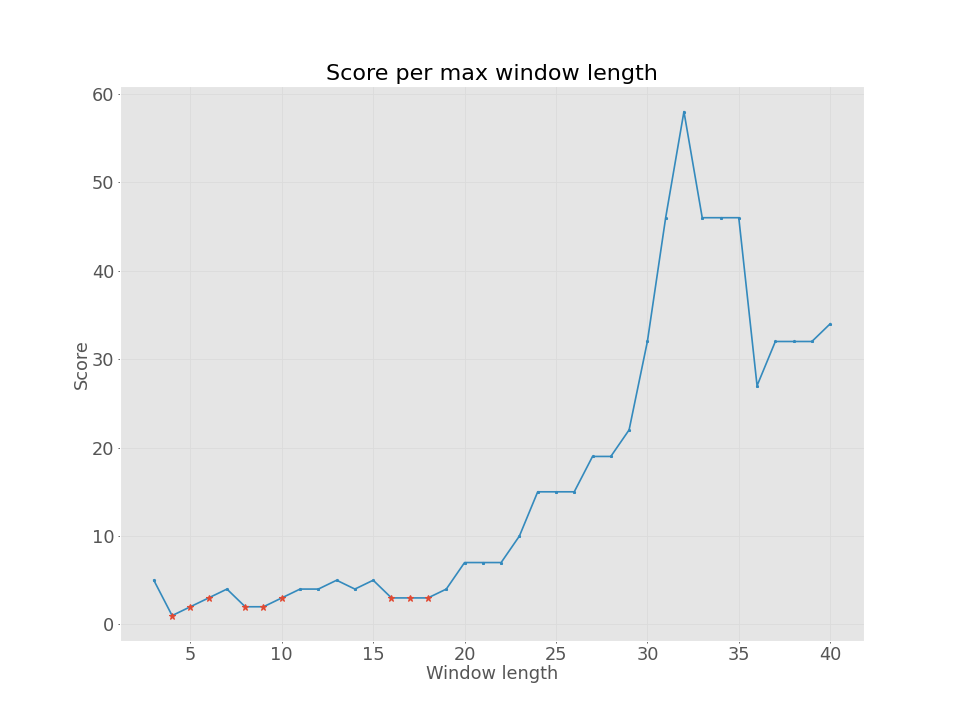

In [7]:
fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
plt.rcParams['xtick.labelsize'] = config.fontsize2
plt.rcParams['ytick.labelsize'] = config.fontsize2
plt.plot(window_lengths, scores1,'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label='Scores')
plt.plot(best_window_lengths1, best_scores1,'C7*', linewidth=config.linewidth, markersize=config.markersize2, label='Best scores')
plt.title('Score per max window length',fontsize=config.fontsize1)
plt.xlabel('Window length',fontsize=config.fontsize2)
plt.ylabel('Score',fontsize=config.fontsize2)
plt.show()

In [8]:
expected_impacts = 2

In [9]:
def calc_proposed_bound(prediction_differences):
    return min(prediction_differences)

def propose_bound(proposed_bounds):
    if len(proposed_bounds) > 0:
        return min(proposed_bounds)
    return None

def calc_score(detected_jumps, expected_jumps_=None):
    if expected_jumps_ is None:
        expected_jumps_ = expected_impacts
    return (expected_jumps_ - detected_jumps)**2

In [10]:
start_time = t.time()
print("Evaluating bounds and window_lengths")

all_scores2 = []
all_proposed_bounds2 = []

for w in range(len(best_window_lengths1)):
    window_length = best_window_lengths1[w]
    bound = best_bounds1[w]
    
    print(f'Analyzing window_length {window_length} with bound {bound}')
    
    jump_indices = []
    predictions = []
    scores = []
    proposed_bounds = []
    
    for i in range(len(config.demos)):
        jump_indices.append([])
        predictions.append(DataSet())
        
        # Detect jumps
        jump_detector = config.jump_detector
        jump_detector.max_window_length = window_length
        jump_detector.bounder.set_bound(bound)
        jump_detector.reset()
        for j in range(len(force_ext[i])):
            jump_detected, info = jump_detector.update(force_ext[i][j])
            predictions[i].append(info[0])
            if jump_detected:
                jump_indices[i].append(j)
        
        # Calculate score
        score = calc_score(len(jump_indices[i]))
        scores.append(score)

        print(f"Score for demonstration file {config.demos[i]} is {score}")

        # Demo is valid
        if score == 0:
            jump_diffs = DataSet([force_ext[i][j] - predictions[i][j] for j in jump_indices[i]])
            proposed_bounds.append(calc_proposed_bound(abs(jump_diffs).value))
    
    proposed_bound = propose_bound(proposed_bounds)
    all_scores2.append(scores)
    all_proposed_bounds2.append(proposed_bound)
    print(f"The proposed bounds are {proposed_bounds} with a proposed value of {proposed_bound}")
    
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Evaluating bounds and window_lengths
Analyzing window_length 4 with bound 4.126768562546804
Score for demonstration file data/demo20.bag is 0
Score for demonstration file data/demo21.bag is 0
Score for demonstration file data/demo22.bag is 0
Score for demonstration file data/demo23.bag is 0
Score for demonstration file data/demo24.bag is 1
The proposed bounds are [4.513471334619922, 5.2426817956102205, 4.793862061177151, 5.982109637983066] with a proposed value of 4.513471334619922
Analyzing window_length 5 with bound 5.62770028548568
Score for demonstration file data/demo20.bag is 0
Score for demonstration file data/demo21.bag is 0
Score for demonstration file data/demo22.bag is 0
Score for demonstration file data/demo23.bag is 1
Score for demonstration file data/demo24.bag is 1
The proposed bounds are [6.011526809023124, 6.183724762402784, 8.221530048734465] with a proposed value of 6.011526809023124
Analyzing window_length 8 with bound 6.441193928215425
Score for demonstration file 

In [11]:
start_time = t.time()
print("Calculating results")

total_scores2 = []
for scores in all_scores2:
    total_scores2.append(sum(scores))
    
print(f'The total scores for window_lengths {best_window_lengths1} with bounds {best_bounds1} are {total_scores2}')

indices2a = [i for i, value in sorted(enumerate(total_scores2), key=lambda x:x[1])]
best_indices2 = [indices2a[0]]
best_total_score2 = total_scores2[indices2a[0]]
index = 1
while index < len(total_scores2) and total_scores2[indices2a[index]] == best_total_score2:
    best_indices2.append(indices2a[index])
    index += 1

best_scores2 = [total_scores2[i] for i in best_indices2]
best_window_lengths2 = [best_window_lengths1[i] for i in best_indices2]
best_bounds2 = [best_bounds1[i] for i in best_indices2]

indices2b = [i for i, value in sorted(enumerate(best_bounds2), key=lambda x : -x[1])]
best_window_length2 = best_window_lengths2[indices2b[0]]
best_score2 = best_scores2[indices2b[0]]
best_bound2 = best_bounds2[indices2b[0]]

print(f'The proposed window length is {best_window_length2} with bound {best_bound2} with score {best_score2}')
indices2c = [i for i,j in enumerate(all_scores2[best_window_lengths1.index(best_window_length2)]) if j > 0]
print(f'The neglected demonstration files are {[config.demos[i] for i in indices2c]}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Calculating results
The total scores for window_lengths [4, 5, 8, 9, 6, 10, 16, 17, 18] with bounds [4.126768562546804, 5.62770028548568, 6.441193928215425, 7.3377394286815765, 6.3506508231217715, 8.997807739027493, 16.809277381745915, 18.500629064362897, 20.2351455255225] are [1, 2, 2, 2, 3, 3, 3, 3, 3]
The proposed window length is 4 with bound 4.126768562546804 with score 1
The neglected demonstration files are ['data/demo24.bag']
--- 0.0009865760803222656 seconds ---
Done


<IPython.core.display.Javascript object>


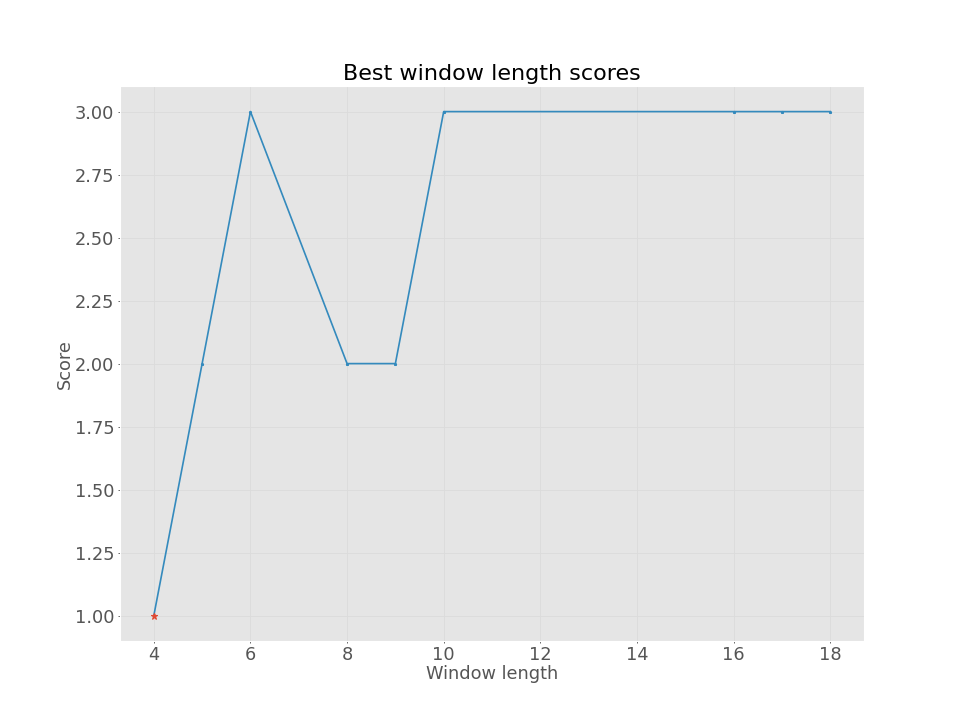

In [12]:
indices_to_plot = np.argsort(best_window_lengths1)

fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
plt.rcParams['xtick.labelsize'] = config.fontsize2
plt.rcParams['ytick.labelsize'] = config.fontsize2
plt.plot([best_window_lengths1[i] for i in indices_to_plot], [total_scores2[i] for i in indices_to_plot],'C1-*', linewidth=config.linewidth, markersize=config.markersize3, label='Scores')
plt.plot(best_window_length2, best_score2,'C7*', linewidth=config.linewidth, markersize=config.markersize2, label='Best score')
plt.title('Best window length scores',fontsize=config.fontsize1)
plt.xlabel('Window length',fontsize=config.fontsize2)
plt.ylabel('Score',fontsize=config.fontsize2)
plt.show()

In [13]:
start_time = t.time()
print("Detecting jumps")

predictions_data = []
bounds_data = []
jump_indices_data = []
impact_indices_data = []

for i in range(len(config.demos)):
    predictions_data.append(DataSet())
    bounds_data.append(DataSet())
    jump_indices_data.append([])
    impact_indices_data.append([])

indices3 = [i for i,j in enumerate(all_scores2[best_window_lengths1.index(best_window_length2)]) if j == 0]
jump_detector = config.jump_detector.copy()
jump_detector.max_window_length = best_window_length2
jump_detector.bounder.set_bound(best_bound2)

for i in indices3:
    
    # Detect jumps
    jump_detector.reset()
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    for j in range(len(force_ext[i][starting_index:ending_index])):
        jump_detected, info = jump_detector.update(force_ext[i][j+starting_index])
        if jump_detected:
            impact_indices_data[i].append(j+starting_index)
        if info[5]:
            jump_indices_data[i].append(j+starting_index)
        predictions_data[i].append(info[0])
        bounds_data[i].append(info[1])
        
print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Detecting jumps
--- 0.33005189895629883 seconds ---
Done


In [14]:
start_time = t.time()
print("Analyzing result")

mean_errors = []

for i in indices3:
    # Print result
    demo = config.demos[i]
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    pred_diff = abs(force_ext[i][starting_index:ending_index] - predictions_data[i])
    mean_error = np.sqrt(np.mean([i**2 for i in pred_diff.value if i is not None]))
    mean_errors.append(mean_error)
    print(f"For demo {demo}, the jump indices are", jump_indices_data[i], "with jump times", force_ext[i][jump_indices_data[i]].time)
    print(f"For demo {demo}, the impact indices are", impact_indices_data[i], "with impact times", force_ext[i][impact_indices_data[i]].time)
    print(f'For demonstration {demo} the mean squared absolute difference between data and prediction is {mean_error}')
    print(f'{max([i for i in pred_diff.value if i is not None])}')
    
print(f'The mean mean error is {np.mean(mean_errors)} and has a minumum value of {min(mean_errors)} and a maximum value of {max(mean_errors)}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Analyzing result
For demo data/demo20.bag, the jump indices are [349, 354, 360] with jump times [1.9609804153442383, 1.989013671875, 2.0220608711242676]
For demo data/demo20.bag, the impact indices are [349, 360] with impact times [1.9609804153442383, 2.0220608711242676]
For demonstration data/demo20.bag the mean squared absolute difference between data and prediction is 1.4285136052436727
9.289870514763692
For demo data/demo21.bag, the jump indices are [337, 343, 364] with jump times [1.888944387435913, 1.9229581356048584, 2.0399508476257324]
For demo data/demo21.bag, the impact indices are [337, 364] with impact times [1.888944387435913, 2.0399508476257324]
For demonstration data/demo21.bag the mean squared absolute difference between data and prediction is 1.8992606878926475
17.289710796042513
For demo data/demo22.bag, the jump indices are [484, 490, 495] with jump times [2.7189292907714844, 2.7519357204437256, 2.778951406478882]
For demo data/demo22.bag, the impact indices are [484

In [15]:
# Print demos and impact indices

print('demos = [')
j = 0
for i in indices3:
    print(f'\t\'{config.demos[i]}\'',end='')
    if j < len(indices3) - 1:
        print(',')
    else:
        print('')
    j += 1
print(']')

print('')

print('impact_intervals = [')
j = 0
for i in indices3:
    print('\t[(', end='')
    for index in impact_indices_data[i]:
        print(index, end=',')
    if j < len(indices3) - 1:
        print(')],')
    else:
        print(')]')
    j += 1
print(']')

print('')

print('jump_intervals = [')
j = 0
for i in indices3:
    print('\t[(', end='')
    for index in jump_indices_data[i]:
        print(index, end=',')
    if j < len(indices3) - 1:
        print(')],')
    else:
        print(')]')
    j += 1
print(']')

demos = [
	'data/demo20.bag',
	'data/demo21.bag',
	'data/demo22.bag',
	'data/demo23.bag'
]

impact_intervals = [
	[(349,360,)],
	[(337,364,)],
	[(484,495,)],
	[(336,345,)]
]

jump_intervals = [
	[(349,354,360,)],
	[(337,343,364,)],
	[(484,490,495,)],
	[(336,341,345,)]
]


In [16]:
start_time = t.time()
print("Finding detection delay")

real_impact_indices_data = []
detection_delays_data = []
detection_delays_indices_data = []

for i in range(len(config.demos)):
    real_impact_indices_data.append([])
    detection_delays_data.append([])
    detection_delays_indices_data.append([])

for i in indices3:
    
    for k in range(2):
        start_compare = 0
        if k > 0:
            end = impact_indices_data[i][-1]+1
            impact_index = impact_indices_data[i][-1]
            start_compare = impact_indices_data[i][0] + 1
            for index in jump_indices_data[i]:
                if index + 1 > start_compare and index + 1 < impact_index:
                    start_compare = index + 1
        else:
            end = impact_indices_data[i][0]+1
        start = max(start_compare,round(end - (jump_detector.max_window_length + 1)))
        
        starting_index = starting_indices[i]
        ending_index = ending_indices[i]
        start -= starting_index
        end -= ending_index
        
        data = abs(force_ext[i][starting_index:ending_index][start:end] - predictions_data[i][start:end])
        if len(data) == 0:
            continue
        impact_detection_time = data[-1].time
        real_impact_index = None
        
        for p in range(len(data) - 2):
            index = len(data) - p - 2
            if data[index].value is None:
                continue
            if data[index].value < data[index+1].value and (data[index-1].value is None or data[index].value < data[index-1].value):
                real_impact_index = start + index + starting_index
                break
        
        if real_impact_index is not None:
            detection_delays_data[i].append(impact_detection_time - data[real_impact_index - start - starting_index].time)
            detection_delays_indices_data[i].append(len(data) - 1 - (real_impact_index - start - starting_index))
        else:
            detection_delays_data[i].append(0)
            detection_delays_indices_data[i].append(0)
            real_impact_index = ending_index - 1
        real_impact_indices_data[i].append(real_impact_index)
    
    print(f'The detection delays for demonstration file {config.demos[i]} are {detection_delays_data[i]}')
    print(f'The detection delays in indices for demonstration file {config.demos[i]} are {detection_delays_indices_data[i]}')

for k in range(2):
    detection_delays = [i[k] for i in detection_delays_data if len(i) > 0]
    detection_delays_indices = [i[k] for i in detection_delays_indices_data if len(i) > 0]
    print(f'Maximal detection delay for {k+1}st impact is {max(detection_delays)}, average_detection_delay is {np.mean(detection_delays)}')
    print(f'Maximal detection delay in indices for {k+1}st impact is {max(detection_delays_indices)}, average_detection_delay is {np.mean(detection_delays_indices)}, median is {int(np.median(detection_delays_indices))}')

print("--- %s seconds ---" % (t.time() - start_time))
print("Done")

Finding detection delay
The detection delays for demonstration file data/demo20.bag are [0.01700115203857422, 0.005034446716308594]
The detection delays in indices for demonstration file data/demo20.bag are [3, 1]
The detection delays for demonstration file data/demo21.bag are [0.011976242065429688, 0]
The detection delays in indices for demonstration file data/demo21.bag are [2, 0]
The detection delays for demonstration file data/demo22.bag are [0.005016326904296875, 0.006010293960571289]
The detection delays in indices for demonstration file data/demo22.bag are [1, 1]
The detection delays for demonstration file data/demo23.bag are [0.012021780014038086, 0]
The detection delays in indices for demonstration file data/demo23.bag are [2, 0]
Maximal detection delay for 1st impact is 0.01700115203857422, average_detection_delay is 0.011503875255584717
Maximal detection delay in indices for 1st impact is 3, average_detection_delay is 2.0, median is 2
Maximal detection delay for 2st impact i

In [17]:
print('impact_detection_delays = [')
j = 0
for i in indices3:
    if len(detection_delays_indices_data[i]) == 0:
        continue
    print('\t[', end='')
    k = 0
    for delay in detection_delays_indices_data[i]:
        print(delay,end='')
        if k < len(detection_delays_indices_data[i]) - 1:
            print(',',end='')
        k += 1
    if j < len(indices3) - 1:
        print('],')
    else:
        print(']')
    j += 1
print(']')

impact_detection_delays = [
	[3,1],
	[2,0],
	[1,1],
	[2,0]
]


<IPython.core.display.Javascript object>


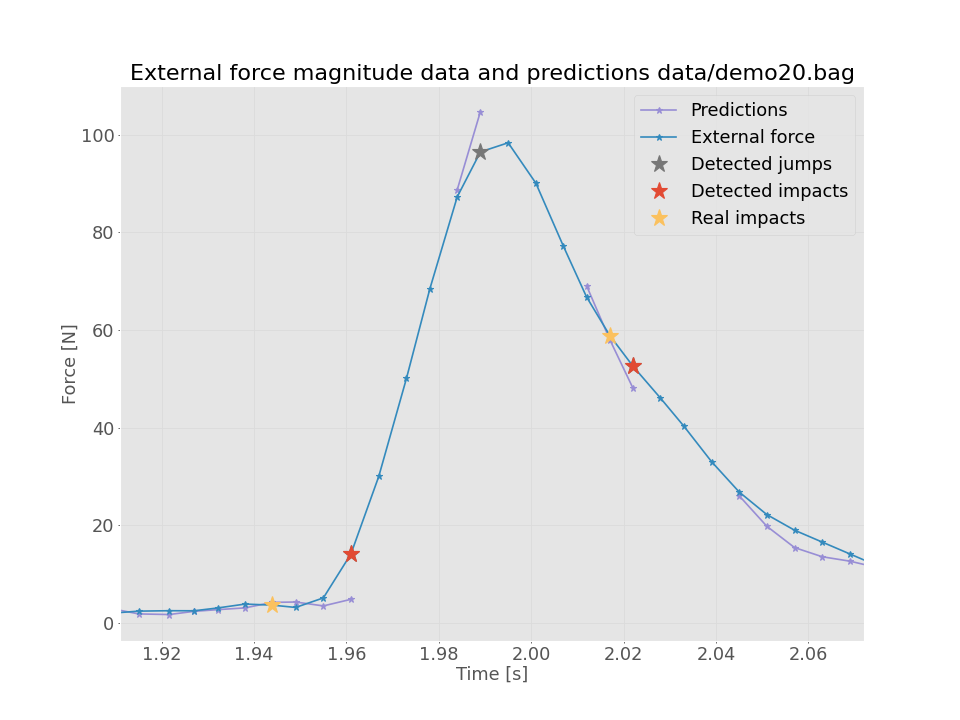

<IPython.core.display.Javascript object>


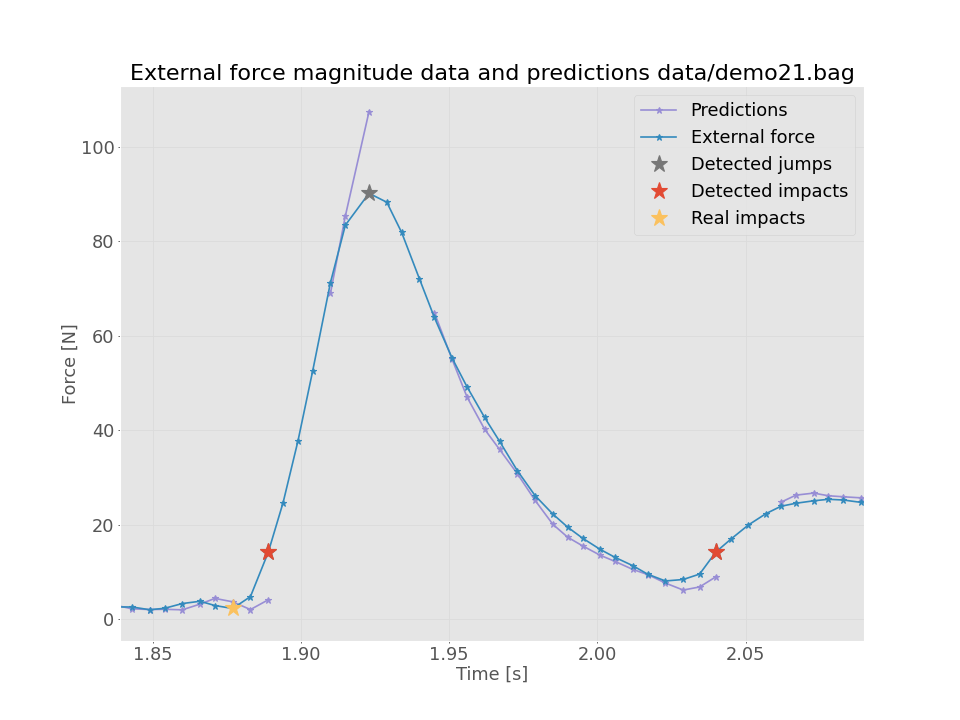

<IPython.core.display.Javascript object>


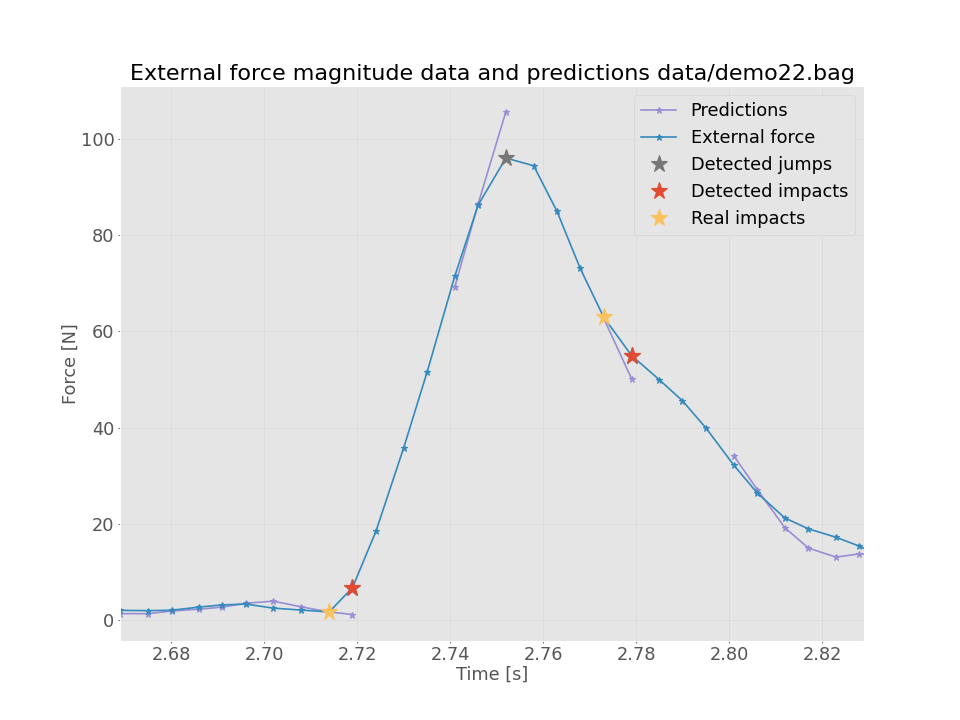

<IPython.core.display.Javascript object>


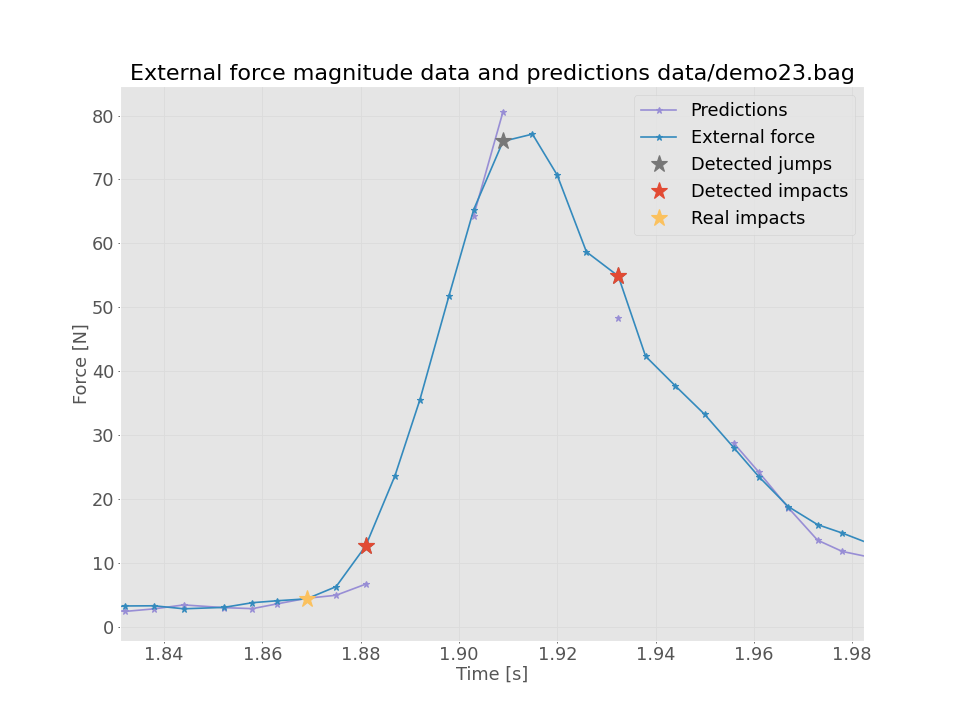

In [18]:
# Plotting external force data

for i in indices3:
    demo = config.demos[i]
    
    ## Plot external force
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Predictions
    plt.plot(predictions_data[i].time, predictions_data[i].value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Predictions')

    # External force data
    plt.plot(force_ext[i].time, force_ext[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='External force')

    # Jumps and impacts
    force_ext_jumps = force_ext[i][jump_indices_data[i]]
    plt.plot(force_ext_jumps.time, force_ext_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
    force_ext_impacts = force_ext[i][impact_indices_data[i]]
    plt.plot(force_ext_impacts.time, force_ext_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
    data_impacts = force_ext[i][[index for index in real_impact_indices_data[i]]]
    plt.plot(data_impacts.time, data_impacts.value, 'C4*', linewidth=config.linewidth, markersize=config.markersize1, label='Real impacts')
    
    # Adding title and labels
    plt.title('External force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()

if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


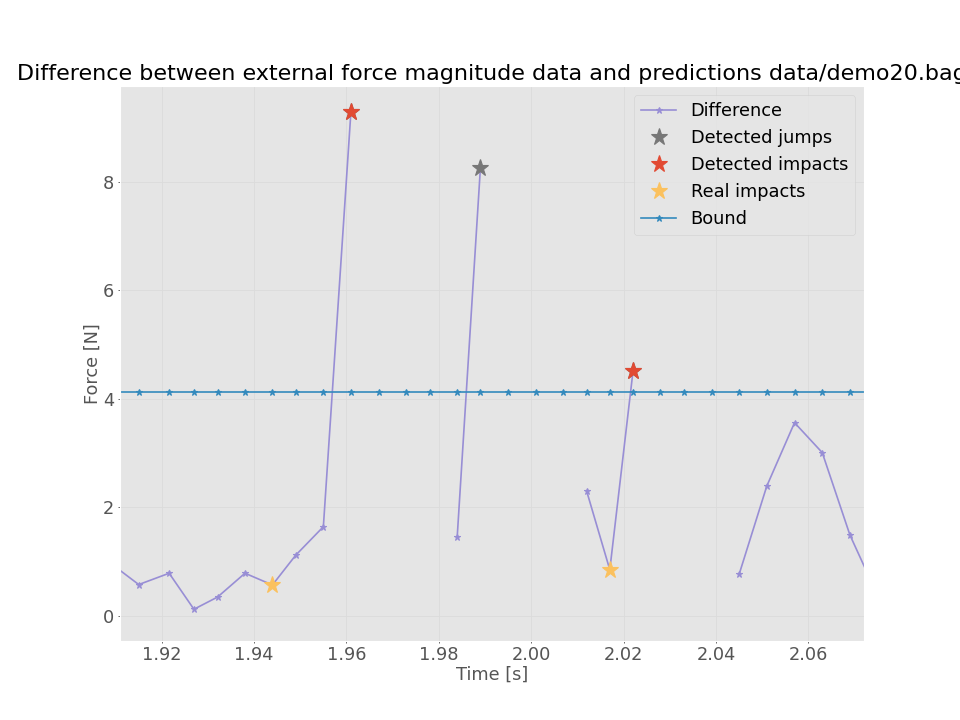

<IPython.core.display.Javascript object>


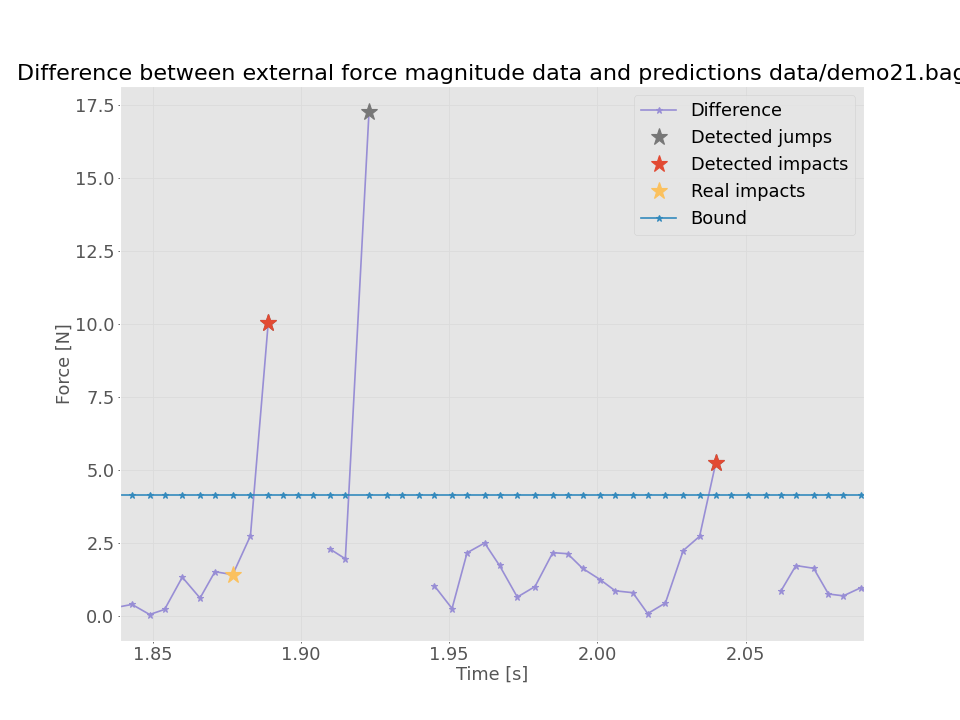

<IPython.core.display.Javascript object>


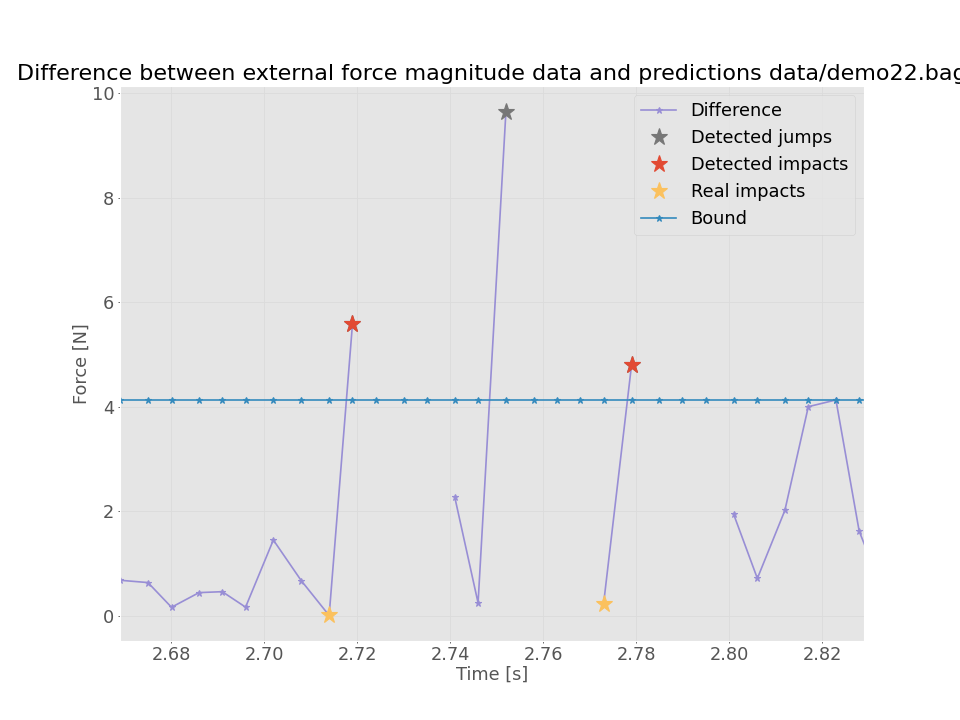

<IPython.core.display.Javascript object>


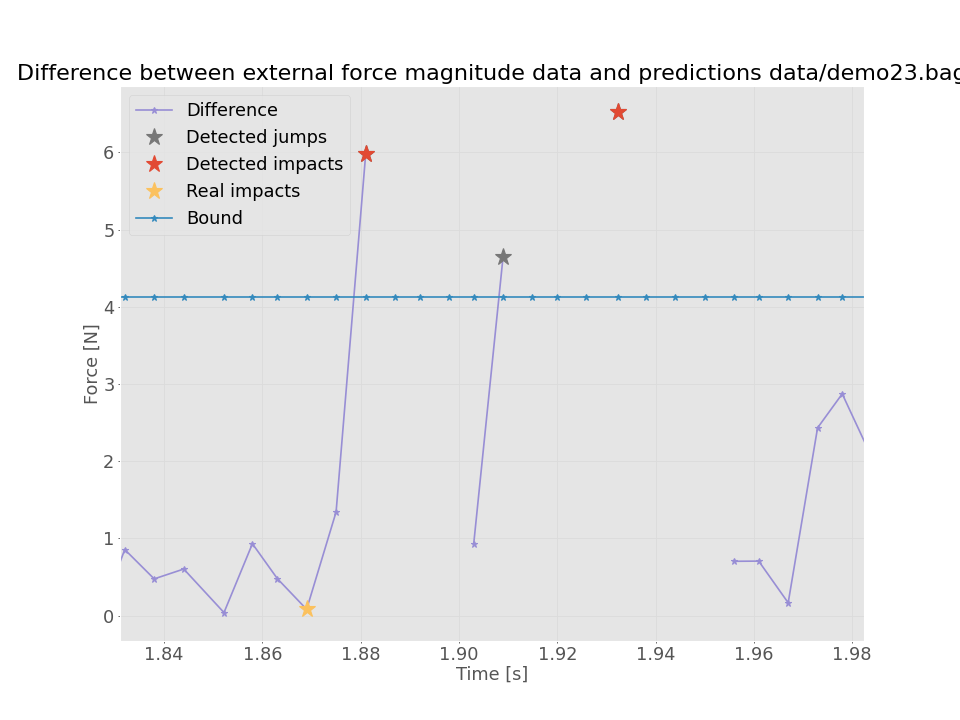

In [19]:
# Plot difference between data and prediction

for i in indices3:
    demo = config.demos[i]
    starting_index = starting_indices[i]
    ending_index = ending_indices[i]
    pred_diff = abs(force_ext[i][starting_index:ending_index] - predictions_data[i])
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Difference between data and prediction
    plt.plot(pred_diff.time, pred_diff.value, 'C2-*', linewidth=config.linewidth, markersize=config.markersize2, label='Difference')
    pred_diff_jumps = pred_diff[[index - starting_index for index in jump_indices_data[i]]]
    plt.plot(pred_diff_jumps.time, pred_diff_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1,label='Detected jumps')
    pred_diff_impacts = pred_diff[[index - starting_index for index in impact_indices_data[i]]]
    plt.plot(pred_diff_impacts.time, pred_diff_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1,label='Detected impacts')
    data_impacts = pred_diff[[index - starting_index for index in real_impact_indices_data[i]]]
    plt.plot(data_impacts.time, data_impacts.value, 'C4*', linewidth=config.linewidth, markersize=config.markersize1, label='Real impacts')
    
    # Bound
    plt.plot(bounds_data[i].time, bounds_data[i].value, 'C1-*', linewidth=config.linewidth, markersize=config.markersize2, label='Bound')
    
    # Adding title and labels
    plt.title('Difference between external force magnitude data and predictions ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Force [N]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


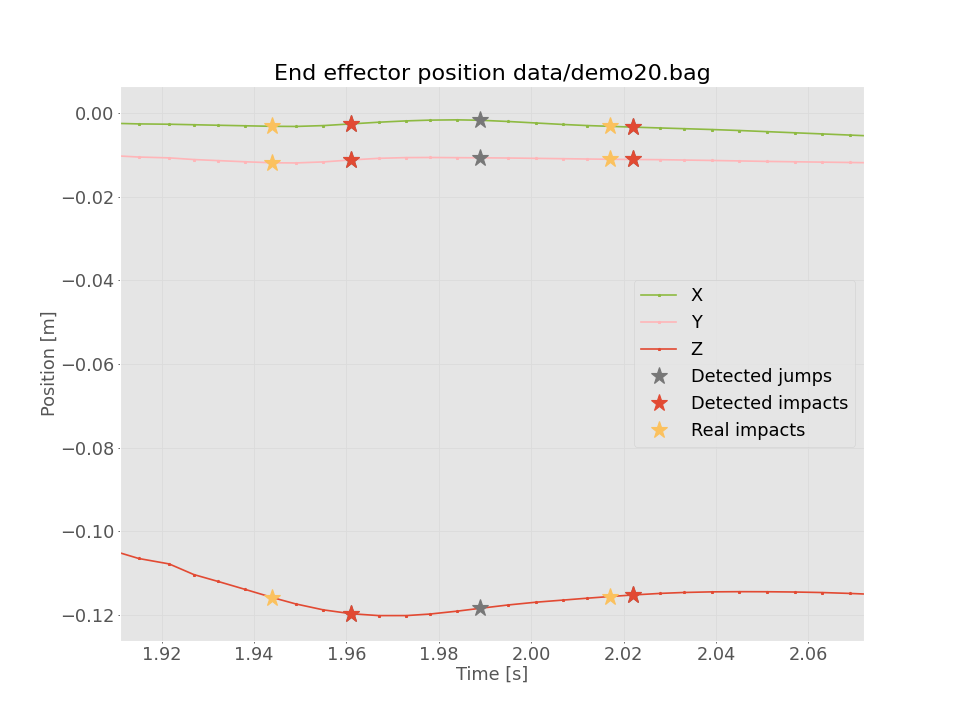

<IPython.core.display.Javascript object>


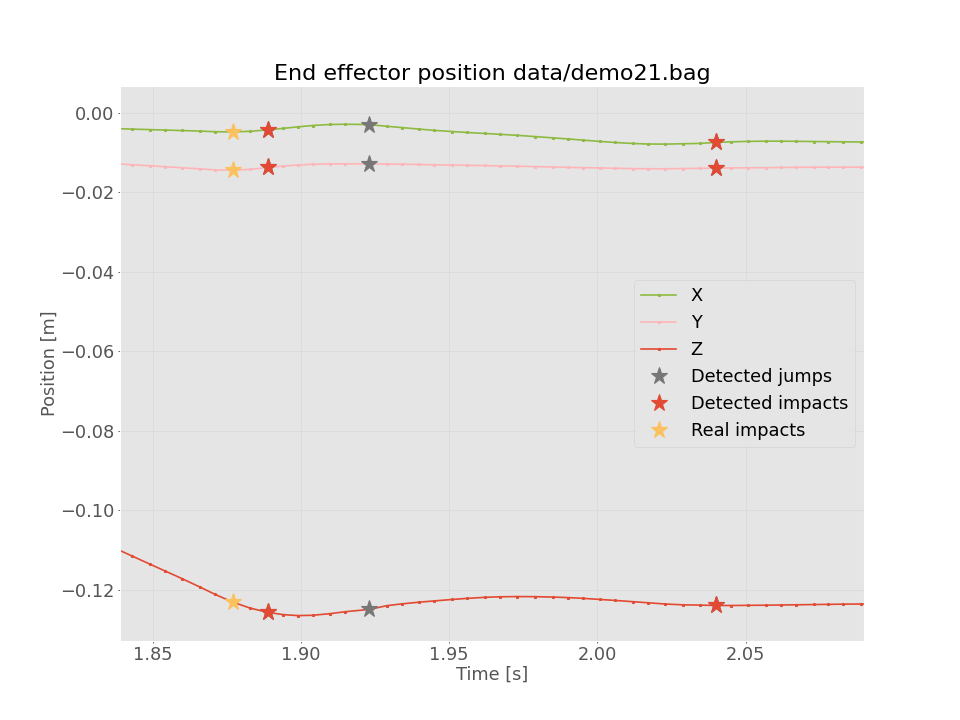

<IPython.core.display.Javascript object>


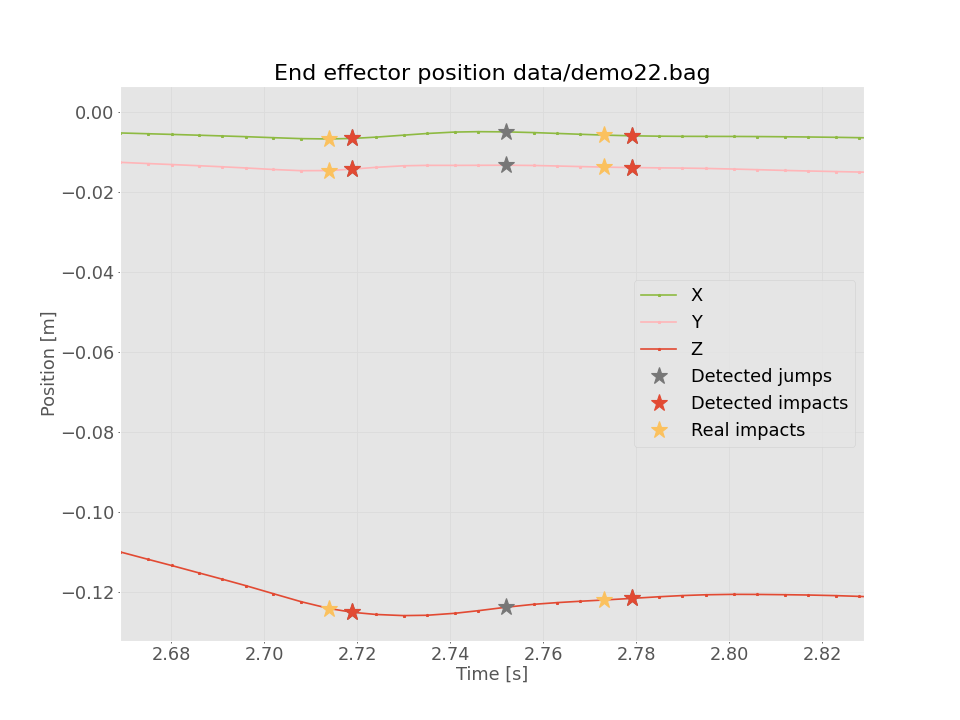

<IPython.core.display.Javascript object>


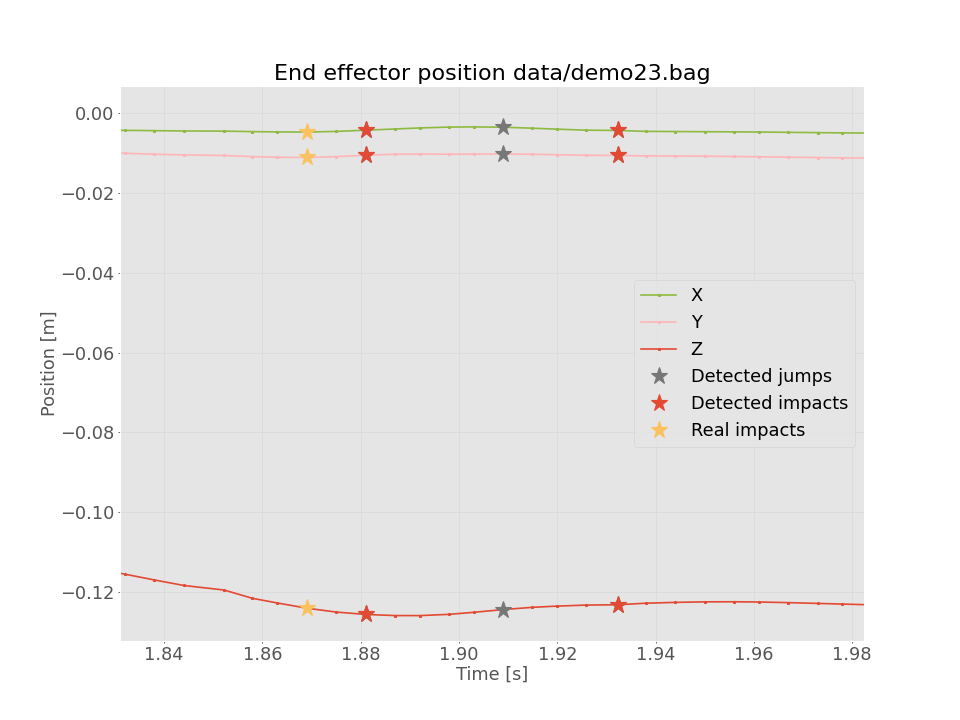

In [20]:
# Plot position data

for i in indices3:
    
    demo = config.demos[i]

    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Position
    for j in range(3):
        plt.plot(position_data[i].time, (position_data[i].get_index(j)-position_data[i].get_index(j)[0]).value, 'C' + str(j+5) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        
    for j in range(3):
        position_jumps = position_data[i].get_index(j)[jump_indices_data[i]]
        plt.plot(position_jumps.time, (position_jumps-position_data[i].get_index(j)[0]).value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
        position_impacts = position_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(position_impacts.time, (position_impacts-position_data[i].get_index(j)[0]).value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
        data_impacts = position_data[i].get_index(j)[[index for index in real_impact_indices_data[i]]]
        plt.plot(data_impacts.time, (data_impacts-position_data[i].get_index(j)[0]).value, 'C4*', linewidth=config.linewidth, markersize=config.markersize1, label='Real impacts')
        
    # Adding title and labels
    plt.title('End effector position ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Position [m]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

<IPython.core.display.Javascript object>


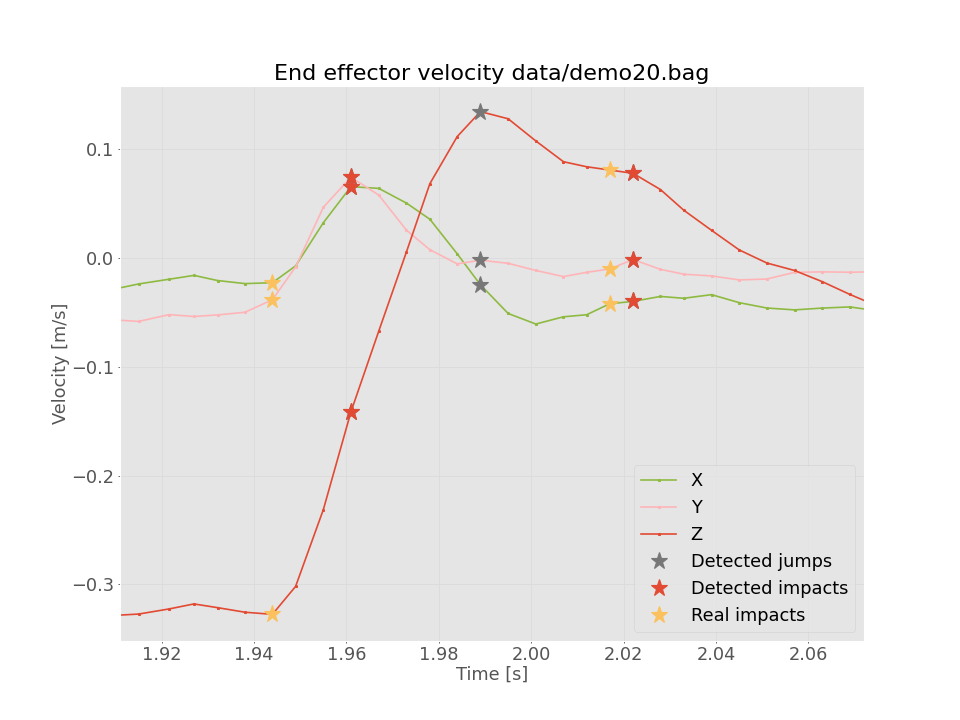

<IPython.core.display.Javascript object>


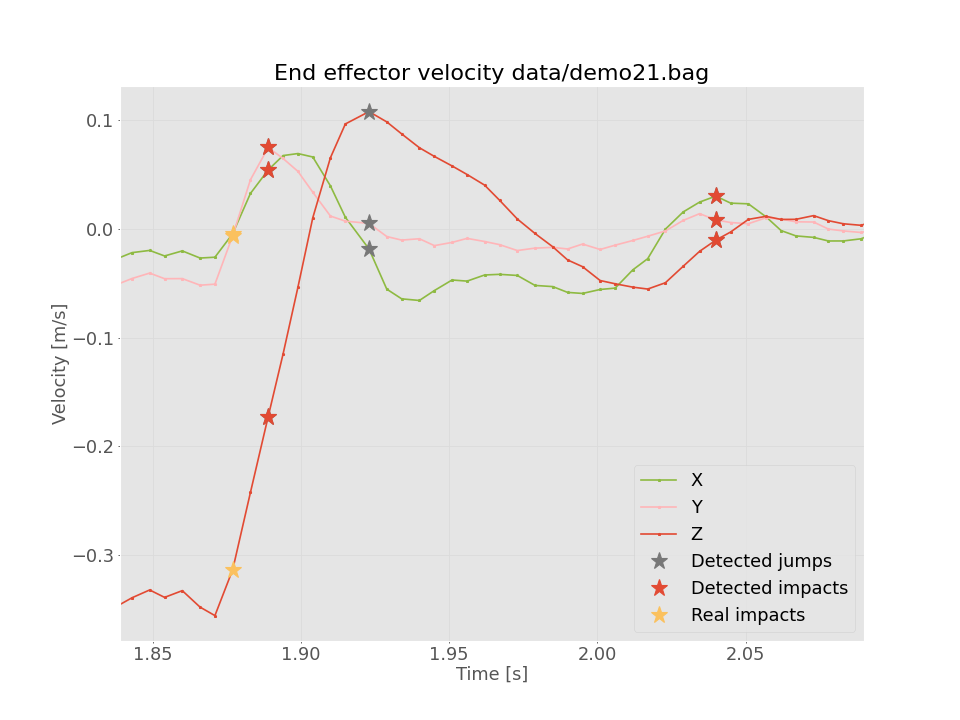

<IPython.core.display.Javascript object>


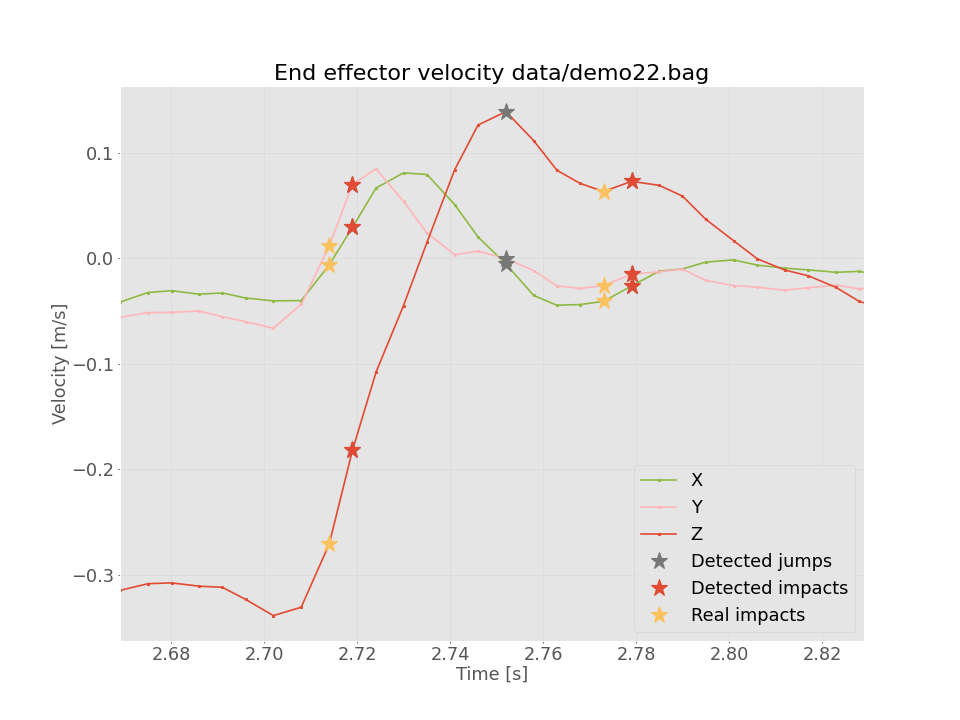

<IPython.core.display.Javascript object>


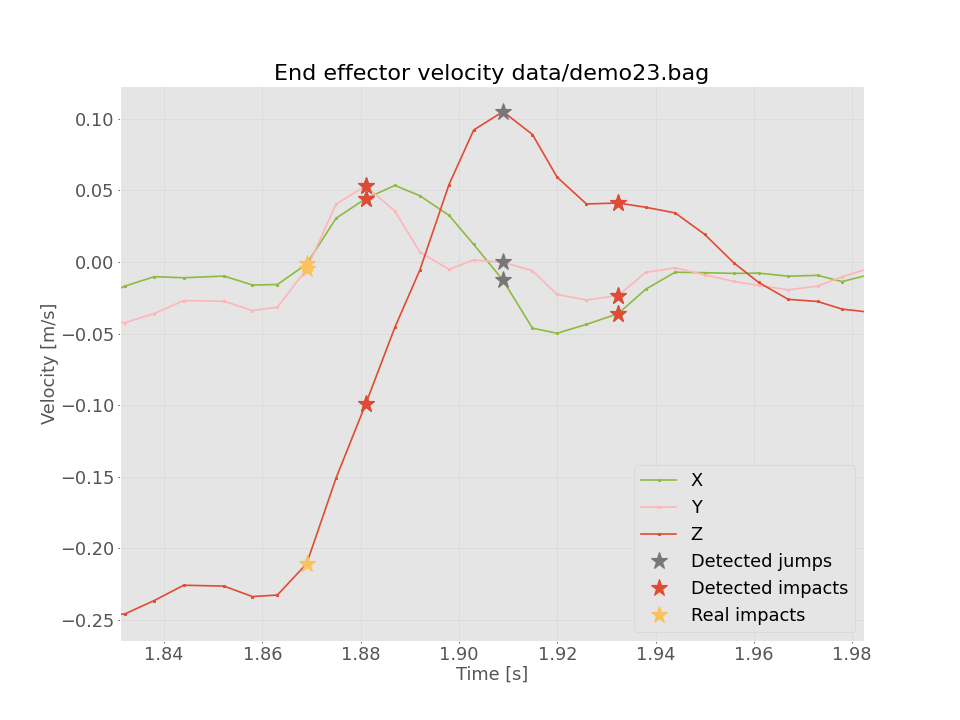

In [21]:
# Plot velocity data

for i in indices3:
    
    demo = config.demos[i]
    
    fig = plt.figure(figsize=config.figsize, dpi=config.dpi)
    plt.rcParams['xtick.labelsize'] = config.fontsize2
    plt.rcParams['ytick.labelsize'] = config.fontsize2

    # Velocity
    for j in range(3):
        plt.plot(velocity_data[i].time, velocity_data[i].get_index(j).value, 'C' + str(j+5) + '-*', linewidth=config.linewidth, markersize=config.markersize3, label=config.labels[j])
        
    for j in range(3):
        velocity_jumps = velocity_data[i].get_index(j)[jump_indices_data[i]]
        plt.plot(velocity_jumps.time, velocity_jumps.value, 'C3*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected jumps')
        velocity_impacts = velocity_data[i].get_index(j)[impact_indices_data[i]]
        plt.plot(velocity_impacts.time, velocity_impacts.value, 'C0*', linewidth=config.linewidth, markersize=config.markersize1, label='Detected impacts')
        data_impacts = velocity_data[i].get_index(j)[[index for index in real_impact_indices_data[i]]]
        plt.plot(data_impacts.time, data_impacts.value, 'C4*', linewidth=config.linewidth, markersize=config.markersize1, label='Real impacts')
        
    # Adding title and labels
    plt.title('End effector velocity ' + demo,fontsize=config.fontsize1)
    plt.xlabel('Time [s]',fontsize=config.fontsize2)
    plt.ylabel('Velocity [m/s]',fontsize=config.fontsize2)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),fontsize=config.fontsize2)
    if config.xlim is not None:
        x_min = force_ext[i][min(jump_indices_data[i])].time + config.xlim[0]
        x_max = force_ext[i][max(jump_indices_data[i])].time + config.xlim[-1]
        plt.xlim((x_min, x_max))

    title = fig.axes[0].get_title() + demo.split('/')[-1].split('\\')[-1]
    if config.save_figs:
        plt.savefig(config.save_figs_location + '/figures/' + title + '.png')

    if config.pickle_figs:
        pickle.dump(fig,open(config.save_figs_location + '/pickles/' + title + '.pickle','wb'))

    if not config.show_figs:
        plt.close()
        
if config.show_figs:
    plt.show()

In [22]:
print("--- Entire script took %s seconds ---" % (t.time() - script_starting_time))

--- Entire script took 133.69919657707214 seconds ---
